In [ ]:
"""
antenna_opt_GA.py
Skrip lengkap: membangun surrogate DNN (multi-output) lalu jalankan Genetic Algorithm (GA)
untuk mencari kombinasi parameter antena terbaik (gain maksimum, S11 minimum, efisiensi tinggi).

Pastikan menginstall:
pip install tensorflow scikit-learn pandas matplotlib numpy
"""

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
RND_SEED = 42
np.random.seed(RND_SEED)
random.seed(RND_SEED)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# 1. Konfigurasi & path file
# -----------------------------
DATA_CSV = 'dataset_patch_rectangular_mixed_DNN.csv' 
MODEL_SAVE = "model_baru.h5"
RESULTS_DIR = "ga_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:

# -----------------------------
# 2. Parameter untuk optimasi
# -----------------------------
# Kita optimasi 4 parameter input: Panjang_Patch_mm, Lebar_Patch_mm, Tebal_Substrat_mm (tetap 1.6), inset_x atau feed pos?
# Dari diskusi kita: kita gunakan parameter: L_patch, W_patch, inset_x, feed_width
# Rentang berdasarkan perhitungan & praktik:
BOUNDS = {
    'L_patch_mm': (5.8, 7.0),        # range sekitar L ~6.428 ± ~10%
    'W_patch_mm': (8.5, 9.8),       # range sekitar W ~9.129 ± ~7%
    'inset_x_mm': (0.5, 3.5),       # kedalaman inset dari tepi (mm)
    'feed_width_mm': (2.0, 4.0)     # lebar jalur feed (mm)
}

# Input fitur urut sesuai dataset / model:
# FEATURE_NAMES = ['panjang_patch_mm','lebar_patch_mm','tebal_substrat_mm','epsilon_r','bandwidth_mhz']
FEATURE_NAMES = ['L_mm','W_mm','h_mm','er','Feed_type','Inset_position', 'VSWR','L_norm','W_norm','h_norm','freq_norm','bw_norm','gain_norm','eff_norm']
# Untuk surrogate: kita pakai subset input yang relevan:
SURROGATE_INPUT_NAMES = ['L_mm','W_mm','h_mm','er','Feed_type','Inset_position', 'VSWR','L_norm','W_norm','h_norm','freq_norm','bw_norm','gain_norm','eff_norm']
# Target output names
TARGET_NAMES = ['Bandwidth_MHz','Resonant_freq_Hz', 'S11_min_dB', 'Peak_gain_dBi', 'Efficiency_pct']
# -----------------------------
# 3. Utility: load dataset & prepare
# -----------------------------
def load_and_prepare(csv_path=DATA_CSV):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Dataset tidak ditemukan: {csv_path}. Upload dataset ke path ini.")

    df = pd.read_csv(csv_path)
    # Check columns
    needed = set(SURROGATE_INPUT_NAMES + TARGET_NAMES)
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Kolom berikut hilang di dataset: {missing}")

    # Jika dataset tidak memiliki kolom 'Tebal_Substrat_mm' bervariasi, tetap berikan nilai  1.6
    # Pastikan tipe float
    df = df.copy()
    df[SURROGATE_INPUT_NAMES] = df[SURROGATE_INPUT_NAMES].astype(float)
    df[TARGET_NAMES] = df[TARGET_NAMES].astype(float)

    return df

# -----------------------------
# 4. Surrogate DNN (train or load)
# -----------------------------
def build_surrogate_model(input_dim, output_dim, units=[128,64,32], dropout=0.15, lr=1e-3):
    model = Sequential()
    model.add(Dense(units[0], activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout))
    for u in units[1:]:
        model.add(Dense(u, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    # Gunakan objek metrics langsung untuk kompatibilitas yang lebih baik
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

def train_surrogate(df, model_path=MODEL_SAVE, retrain=False):
    X = df[SURROGATE_INPUT_NAMES].values
    y = df[TARGET_NAMES].values

    # Scaler untuk input dan output
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=RND_SEED)

    if os.path.exists(model_path) and not retrain:
        print("Memuat model surrogate dari:", model_path)
        try:
            # Coba muat dengan compile=False untuk menghindari masalah deserialisasi metrics
            model = load_model(model_path, compile=False)
            # Compile ulang dengan metrics yang benar (menggunakan objek langsung)
            opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=opt, 
                          loss=tf.keras.losses.MeanSquaredError(), 
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])
            print("Model berhasil dimuat dan dikompilasi ulang.")
        except Exception as e:
            print(f"Error saat memuat model: {e}")
            print("Mencoba memuat dengan custom_objects...")
            # Alternatif: gunakan custom_objects
            custom_objects = {
                'mse': tf.keras.losses.MeanSquaredError(),
                'mae': tf.keras.metrics.MeanAbsoluteError()
            }
            model = load_model(model_path, custom_objects=custom_objects, compile=False)
            opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=opt, 
                          loss=tf.keras.losses.MeanSquaredError(), 
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])
    else:
        print("Melatih model surrogate DNN...")
        model = build_surrogate_model(input_dim=X_train.shape[1], output_dim=y_train.shape[1],
                                      units=[128,64,32], dropout=0.15, lr=1e-3)
        es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
        mc = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
        history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=8, callbacks=[es, mc], verbose=1)
        print("Pelatihan selesai. Model tersimpan ke:", model_path)

    # Evaluate (use scaler transforms stored in memory)
    # Return model and scalers
    return model, scaler_X, scaler_y, (X_train, X_test, y_train, y_test)


In [9]:

# -----------------------------
# 5. GA: implementasi sederhana
# -----------------------------
# Representasi kromosom: vector float [L_patch, W_patch, inset_x, feed_width]
def sample_individual(bounds):
    """Buat satu individu acak dalam bounds (dict)"""
    return np.array([np.random.uniform(*bounds[k]) for k in bounds.keys()])

def decode_individual(ind):
    """Map kromosom ke dict parameter"""
    keys = list(BOUNDS.keys())
    return {k: float(ind[i]) for i,k in enumerate(keys)}

def ensure_bounds(ind, bounds):
    out = np.copy(ind)
    for i,k in enumerate(bounds.keys()):
        lo, hi = bounds[k]
        if out[i] < lo: out[i] = lo
        if out[i] > hi: out[i] = hi
    return out

# Genetic operators
def tournament_selection(pop, fitnesses, k=3):
    idxs = np.random.randint(0, len(pop), size=k)
    best = idxs[np.argmin(fitnesses[idxs])]  # kita minimisasi fitness (jadi lebih kecil lebih baik)
    return pop[best].copy()

def crossover(parent1, parent2, cr=0.9):
    # arithmetic crossover
    if np.random.rand() < cr:
        alpha = np.random.rand(len(parent1))
        child1 = alpha * parent1 + (1-alpha) * parent2
        child2 = alpha * parent2 + (1-alpha) * parent1
        return child1, child2
    else:
        return parent1.copy(), parent2.copy()

def mutation(ind, bounds, mu=0.1):
    # gaussian mutation per gen
    out = ind.copy()
    for i,k in enumerate(bounds.keys()):
        if np.random.rand() < mu:
            lo, hi = bounds[k]
            sigma = 0.05 * (hi - lo)
            out[i] += np.random.normal(0, sigma)
    return ensure_bounds(out, bounds)


In [10]:

# -----------------------------
# 6. Fitness: pakai surrogate predictions
# -----------------------------
def fitness_from_surrogate(individual, model, scaler_X, scaler_y):
    """
    individual: array [L,W,inset,feedwidth]
    Kita perlu membentuk input sesuai SURROGATE_INPUT_NAMES:
    SURROGATE_INPUT_NAMES = ['Panjang_Patch_mm','Lebar_Patch_mm','Tebal_Substrat_mm','Epsilon_r','Bandwidth_MHz']
    - Kita isi Tebal_Substrat_mm = 1.6
    - Epsilon_r = 4.4 (FR-4)
    - Bandwidth_MHz: perkiraan awal -> gunakan formula sederhana atau ambil nilai rata-rata dataset.
      Untuk fairness, kita ambil bandwidth perkiraan berdasarkan proporsi: gunakan nilai mean dari dataset
      (fitur bandwidth sebaiknya dimodifikasi bila ingin optimasi berbeda).
    """
    L, W, inset_x, feed_w = individual

    # Prepare feature vector
    # Bandwidth: approximated as function of geometry: gunakan pendekatan empiris: bw ~ k*(h/W)*f0*1000
    # tapi agar konsisten dengan data training, lebih baik gunakan mean bandwidth dari dataset.
    # Jadi kita set bandwidth_mean here from training scaler? We'll use a pragmatic constant:
    bandwidth_guess = 300.0  # MHz (perkiraan, bisa diganti)
    feat = np.array([[L, W, 1.6, 4.4, bandwidth_guess]], dtype=float)
    feat_scaled = scaler_X.transform(feat)
    pred_scaled = model.predict(feat_scaled, verbose=0)
    pred = scaler_y.inverse_transform(pred_scaled)[0]  # [Gain_dBi, S11_dB, Efisiensi]
    gain = float(pred[0])
    s11 = float(pred[1])   # dB (negative preferred)
    eff = float(pred[2])   # percent

    # konstruk fitness: kita ingin memaksimalkan gain & eff, dan meminimalkan S11 (lebih negatif lebih baik)
    # transform ke scoring (lebih kecil fitness = lebih baik) -> gunakan negative sum of normalized scores
    # Normalisasi: use typical expected ranges
    gain_range = (0.0, 10.0)         # expected gain dBi
    s11_range = (-40.0, -5.0)        # expected S11 in dB (lower better)
    eff_range = (20.0, 95.0)         # efficiency %

    # normalize to [0,1]
    gain_n = (gain - gain_range[0]) / (gain_range[1] - gain_range[0])
    s11_n = (s11 - s11_range[0]) / (s11_range[1] - s11_range[0])  # note: if s11 closer to -40 -> near 0
    eff_n = (eff - eff_range[0]) / (eff_range[1] - eff_range[0])

    # We want: high gain_n -> good, low s11_n -> good (because s11_n maps -40->0 best, -5->1 worst), high eff_n -> good
    # Convert to fitness (to minimize): fitness = - (w1*gain_n + w2*(1 - s11_n) + w3*eff_n)
    w1, w2, w3 = 0.4, 0.3, 0.3
    score = -(w1 * gain_n + w2 * (1.0 - s11_n) + w3 * eff_n)

    # To turn into positive minimization, just return score (more negative = better)
    # but some GA impl expects positive; we will minimize directly using this score (lower is better).
    return score, {'gain':gain, 's11':s11, 'eff':eff}


In [11]:

# -----------------------------
# 7. Run GA
# -----------------------------
def run_ga(model, scaler_X, scaler_y, bounds=BOUNDS,
           pop_size=40, generations=60, cx_prob=0.9, mut_prob=0.2,
           tournament_k=3):
    # Initialize population
    keys = list(bounds.keys())
    pop = [sample_individual(bounds) for _ in range(pop_size)]
    fitnesses = np.full(pop_size, np.inf)
    details = [None]*pop_size

    best_history = []
    mean_history = []

    for gen in range(generations):
        # Evaluate all (but reuse if already evaluated)
        for i, ind in enumerate(pop):
            if fitnesses[i] == np.inf:
                fit, info = fitness_from_surrogate(ind, model, scaler_X, scaler_y)
                fitnesses[i] = fit
                details[i] = info

        # Logging
        best_idx = np.argmin(fitnesses)
        best_history.append(fitnesses[best_idx])
        mean_history.append(np.mean(fitnesses))
        print(f"[Gen {gen+1}/{generations}] best fitness = {fitnesses[best_idx]:.6f}, mean = {mean_history[-1]:.6f}")

        # Create next generation
        new_pop = []
        while len(new_pop) < pop_size:
            # selection
            p1 = tournament_selection(pop, fitnesses, k=tournament_k)
            p2 = tournament_selection(pop, fitnesses, k=tournament_k)
            # crossover
            c1, c2 = crossover(p1, p2, cr=cx_prob)
            # mutation
            c1 = mutation(c1, bounds, mu=mut_prob)
            c2 = mutation(c2, bounds, mu=mut_prob)
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)
        # replace
        pop = new_pop
        fitnesses = np.full(pop_size, np.inf)
        details = [None]*pop_size

    # Final evaluation
    final_infos = []
    final_fits = []
    for ind in pop:
        fit, info = fitness_from_surrogate(ind, model, scaler_X, scaler_y)
        final_fits.append(fit)
        final_infos.append((ind.copy(), fit, info))

    # sort by fitness
    final_infos_sorted = sorted(final_infos, key=lambda x: x[1])
    return final_infos_sorted, best_history, mean_history

# -----------------------------
# 8. Post-processing & visualisasi
# -----------------------------
def visualize_ga(best_history, mean_history, final_infos_sorted):
    # Fitness evolusi
    plt.figure(figsize=(8,4))
    plt.plot(best_history, label='Best fitness per gen')
    plt.plot(mean_history, label='Mean fitness per gen')
    plt.xlabel('Generasi')
    plt.ylabel('Fitness (lebih kecil lebih baik)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,'ga_fitness_evolution2.png'), dpi=200)
    plt.show()

    # Show top 10 solutions
    topk = min(10, len(final_infos_sorted))
    rows = []
    for i in range(topk):
        ind, fit, info = final_infos_sorted[i]
        params = decode_individual(ind)
        rows.append({**params, 'fitness':fit, 'pred_gain':info['gain'], 'pred_s11':info['s11'], 'pred_eff':info['eff']})
    df_top = pd.DataFrame(rows)
    df_top.to_csv(os.path.join(RESULTS_DIR,'ga_top10_solutions.csv'), index=False)
    print("Top solutions saved to:", os.path.join(RESULTS_DIR,'ga_top10_solutions2.csv'))
    display(df_top)
    # Scatter of parameter distributions among top 10
    plt.figure(figsize=(6,4))
    plt.scatter(df_top['L_patch_mm'], df_top['W_patch_mm'], c=np.arange(len(df_top)), cmap='viridis')
    plt.xlabel('L_patch_mm'); plt.ylabel('W_patch_mm'); plt.title('Top solutions: L vs W')
    plt.grid(True); plt.tight_layout(); plt.savefig(os.path.join(RESULTS_DIR,'top_L_vs_W2.png'), dpi=200)
    plt.show()

Memuat dataset...
Dataset shape: (500, 11)
Memuat model surrogate dari: model_2.h5
Model berhasil dimuat dan dikompilasi ulang.
Menjalankan Genetic Algorithm...


2025-11-22 18:00:01.178610: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fbde00045e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-22 18:00:01.179407: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-22 18:00:01.300564: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-22 18:00:01.532018: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1763809202.420670  246136 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[Gen 1/60] best fitness = 0.028748, mean = 0.031822
[Gen 2/60] best fitness = 0.028748, mean = 0.030114
[Gen 3/60] best fitness = 0.028793, mean = 0.029414
[Gen 4/60] best fitness = 0.028722, mean = 0.029125
[Gen 5/60] best fitness = 0.028729, mean = 0.028910
[Gen 6/60] best fitness = 0.028634, mean = 0.028831
[Gen 7/60] best fitness = 0.028602, mean = 0.028757
[Gen 8/60] best fitness = 0.028589, mean = 0.028711
[Gen 9/60] best fitness = 0.028593, mean = 0.028666
[Gen 10/60] best fitness = 0.028576, mean = 0.028646
[Gen 11/60] best fitness = 0.028563, mean = 0.028631
[Gen 12/60] best fitness = 0.028545, mean = 0.028597
[Gen 13/60] best fitness = 0.028539, mean = 0.028584
[Gen 14/60] best fitness = 0.028539, mean = 0.028571
[Gen 15/60] best fitness = 0.028539, mean = 0.028596
[Gen 16/60] best fitness = 0.028539, mean = 0.028589
[Gen 17/60] best fitness = 0.028539, mean = 0.028557
[Gen 18/60] best fitness = 0.028539, mean = 0.028544
[Gen 19/60] best fitness = 0.028539, mean = 0.028566
[G

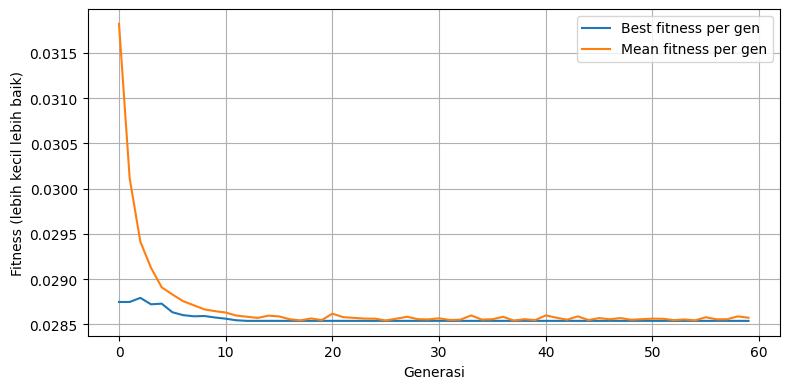

Top solutions saved to: ga_results/ga_top10_solutions2.csv


,L_patch_mm,W_patch_mm,inset_x_mm,feed_width_mm,fitness,pred_gain,pred_s11,pred_eff
0,5.8,9.8,1.931081,3.525440,0.028539,5.297857,3.336271,-22.24984
1,5.8,9.8,1.986459,3.295582,0.028539,5.297857,3.336271,-22.24984
2,5.8,9.8,1.984192,3.324677,0.028539,5.297857,3.336271,-22.24984
3,5.8,9.8,2.131017,3.440749,0.028539,5.297857,3.336271,-22.24984
4,5.8,9.8,2.047311,3.405810,0.028539,5.297857,3.336271,-22.24984
5,5.8,9.8,1.980662,3.410322,0.028539,5.297857,3.336271,-22.24984
6,5.8,9.8,2.033597,3.350578,0.028539,5.297857,3.336271,-22.24984
7,5.8,9.8,2.348820,3.370702,0.028539,5.297857,3.336271,-22.24984
8,5.8,9.8,1.952720,3.391389,0.028539,5.297857,3.336271,-22.24984
9,5.8,9.8,1.945329,3.385429,0.028539,5.297857,3.336271,-22.24984


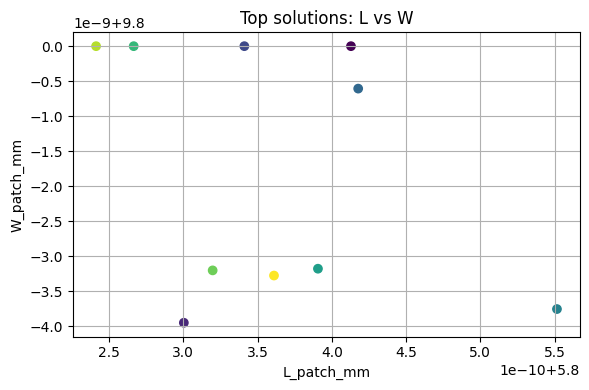

Best solution saved to: ga_results/ga_best_solution2.csv
Selesai. Periksa folder ga_results untuk file hasil.


In [12]:

# -----------------------------
# 9. Main flow
# -----------------------------
def main():
    print("Memuat dataset...")
    df = load_and_prepare(DATA_CSV)
    print("Dataset shape:", df.shape)
    # Train or load surrogate
    model, scaler_X, scaler_y, split = train_surrogate(df, model_path=MODEL_SAVE, retrain=False)

    # Run GA (note: loop akan memanggil surrogate berulang => cepat)
    print("Menjalankan Genetic Algorithm...")
    final_infos_sorted, best_hist, mean_hist = run_ga(model, scaler_X, scaler_y,
                                                      bounds=BOUNDS, pop_size=40, generations=60,
                                                      cx_prob=0.9, mut_prob=0.2, tournament_k=3)

    # Visualize & save top results
    visualize_ga(best_hist, mean_hist, final_infos_sorted)

    # Save best solution detail
    best_ind, best_fit, best_info = final_infos_sorted[0]
    best_params = decode_individual(best_ind)
    best_row = {**best_params, 'fitness':best_fit, 'pred_gain':best_info['gain'], 'pred_s11':best_info['s11'], 'pred_eff':best_info['eff']}
    pd.DataFrame([best_row]).to_csv(os.path.join(RESULTS_DIR,'ga_best_solution2.csv'), index=False)
    print("Best solution saved to:", os.path.join(RESULTS_DIR,'ga_best_solution2.csv'))
    print("Selesai. Periksa folder", RESULTS_DIR, "untuk file hasil.")

if __name__ == "__main__":
    main()